In [1]:
import os, sys
import glob
import iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

try:
    import general_io as gio
    import timeseries
except ImportError:
    raise ImportError('Must run this script from anywhere within the ocean-analysis git repo')

In [2]:
pr_files = glob.glob('/g/data/r87/dbi599/CMIP?/CMIP/*/*/historical/*/Ayr/pr/*/*/pr-pe-region-sum-anomaly_Ayr_*-cumsum.nc')
pr_files_cmip6 = glob.glob('/g/data/r87/dbi599/CMIP6/CMIP/*/*/historical/*/Ayr/pr/*/*/pr-pe-region-sum-anomaly_Ayr_*-cumsum.nc')

In [3]:
tasga_files = ['/g/data/r87/dbi599/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Ayr/tas/gn/v20191115/tasga_Ayr_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc',
               '/g/data/r87/dbi599/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ayr/tas/gn/v20190308/tasga_Ayr_CESM2_historical_r1i1p1f1_gn_185001-201412.nc',
               '/g/data/r87/dbi599/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Ayr/tas/gr1/v20190726/tasga_Ayr_GFDL-ESM4_historical_r1i1p1f1_gr1_185001-201412.nc',
               '/g/data/r87/dbi599/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Ayr/tas/gr/v20180803/tasga_Ayr_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc']      

In [4]:
def create_pr_df(file_list, time_bounds):
    """Create pr dataframe"""

    data_dict = {}
    time_constraint = gio.get_time_constraint(time_bounds)
    for pr_file in file_list:
        cube = iris.load_cube(pr_file, 'precipitation_flux')
        cube = gio.check_time_units(cube, new_calendar='365_day')
        cube = cube.extract(time_constraint)
        try:
            model_name = cube.attributes['model_id']
        except KeyError:
            model_name = cube.attributes['source_id']
        if not model_name in ['GISS-E2-R', 'FGOALS-g3']:
            cum_anom = cube[-1, -1, -1].data - cube[0, -1, -1].data
            data_dict[model_name] = cum_anom

    df = pd.DataFrame(data_dict.items(), columns=['Model', 'Change in P'])
    
    return df


def create_tasga_df(file_list, time_bounds):
    """Create tasga dataframe"""

    data_dict = {}
    time_constraint = gio.get_time_constraint(time_bounds)
    for pr_file in file_list:
        cube = iris.load_cube(pr_file, 'air_temperature')
        cube = gio.check_time_units(cube, new_calendar='365_day')
        cube = cube.extract(time_constraint)
        try:
            model_name = cube.attributes['model_id']
        except KeyError:
            model_name = cube.attributes['source_id']
        trend = timeseries.calc_trend(cube, per_yr=True)
        data_dict[model_name] = trend

    df = pd.DataFrame(data_dict.items(), columns=['Model', 'Linear trend (C/yr)'])
    
    return df

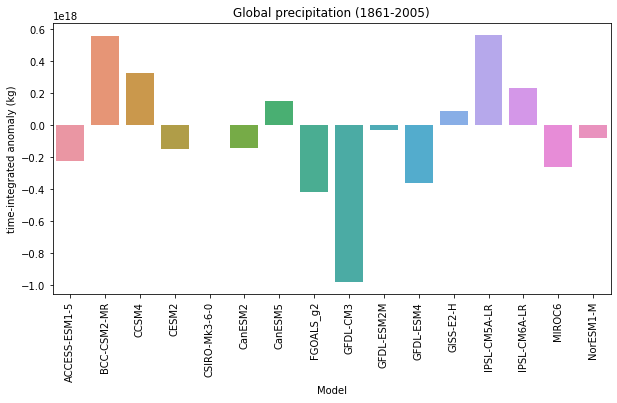

In [10]:
df = create_pr_df(pr_files, ['1861-01-01', '2005-12-31'])
plt.figure(figsize=(10,5))
chart = sns.barplot(x="Model", y="Change in P", data=df.sort_values('Model'))
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.ylabel('time-integrated anomaly (kg)')
plt.title('Global precipitation (1861-2005)')
plt.show()

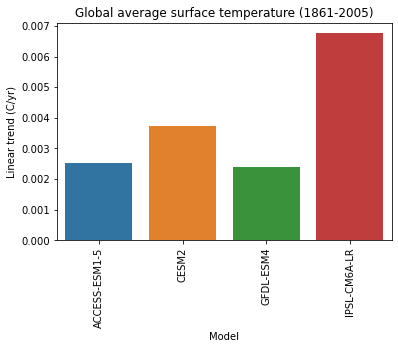

In [11]:
df = create_tasga_df(tasga_files, ['1861-01-01', '2005-12-31'])
plt.figure()
chart = sns.barplot(x="Model", y="Linear trend (C/yr)", data=df.sort_values('Model'))
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
plt.title('Global average surface temperature (1861-2005)')
plt.show()